# t-SNE on Donors Choose dataset 

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [11]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [12]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [13]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


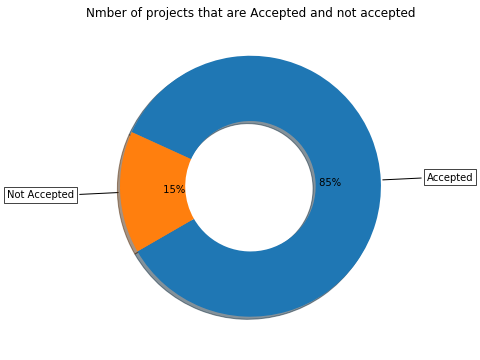

In [14]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
# Showing project approved /not approved output % and Shadow styling  has taken from - https://matplotlib.org/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py

y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]


wedges, texts,autotexts = ax.pie(data, wedgeprops=dict(width=0.5),startangle=-150,autopct='%   .0f%%',shadow=True)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

**Key take away: The Total number of 109,248 submitted projects - 85% (92706 no's) are aproved and 15% (16542) are not approved**


### 1.2.1 Univariate Analysis: School State

In [15]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

'''# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')
'''

'# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620\n\nscl = [[0.0, \'rgb(242,240,247)\'],[0.2, \'rgb(218,218,235)\'],[0.4, \'rgb(188,189,220)\'],            [0.6, \'rgb(158,154,200)\'],[0.8, \'rgb(117,107,177)\'],[1.0, \'rgb(84,39,143)\']]\n\ndata = [ dict(\n        type=\'choropleth\',\n        colorscale = scl,\n        autocolorscale = False,\n        locations = temp[\'state_code\'],\n        z = temp[\'num_proposals\'].astype(float),\n        locationmode = \'USA-states\',\n        text = temp[\'state_code\'],\n        marker = dict(line = dict (color = \'rgb(255,255,255)\',width = 2)),\n        colorbar = dict(title = "% of pro")\n    ) ]\n\nlayout = dict(\n        title = \'Project Proposals % of Acceptance Rate by US States\',\n        geo = dict(\n            scope=\'usa\',\n            projection=dict( type=\'albers usa\' ),\n            showlakes = True,\n            lakecolor = \'rgb(255, 255, 255)\',\n        ),\n    )\n\nfig = go.Figure(data=dat

In [16]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


**Key take away: **

**1. In previous analysis - on an average 85% projects are approved out of which New Hampshire(NH), Ohio(OH), Washington(WA) , North Dakota(ND) and Delaware(DE) are the States with highest % approvals.** 

**2. There is some variability on Project approval rate based on the State name/code, that tells state code is a one of the key feature to predict whether Project will be approved or not. **



In [17]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values),rotation='vertical')
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    
    plt.show()

In [18]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False,):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5),)
    print("="*50)
    print(temp.tail(5))

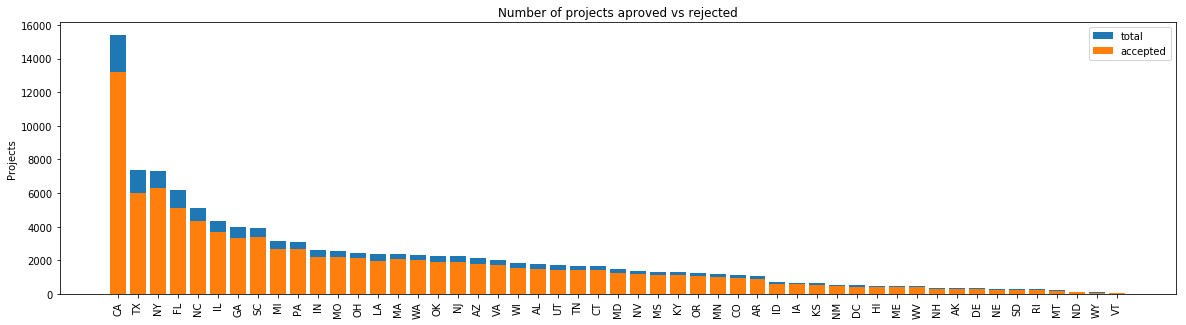

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [19]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)


**Key Take away**:

**1. There is a lot of variability on the number of projects submitted across states. ** 

**2. It has been observed that Every state has greater than 80% success rate in approval. **

           

### 1.2.2 Univariate Analysis: teacher_prefix

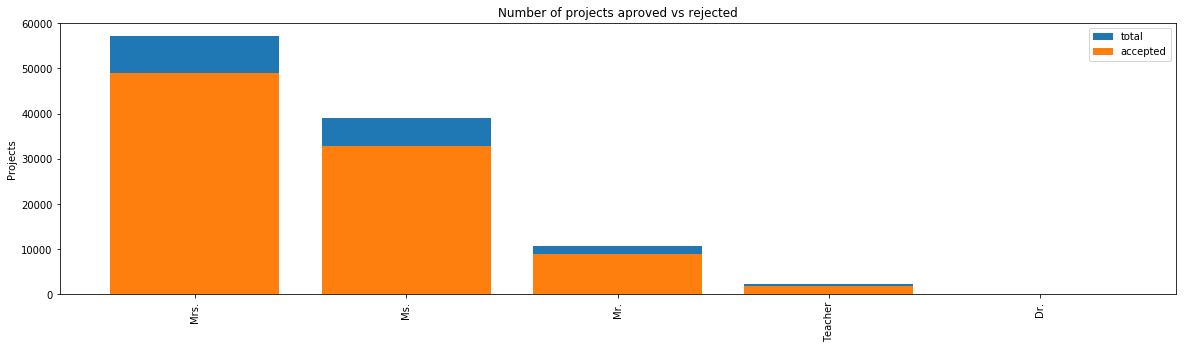

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                49000  57272  0.855566
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                49000  57272  0.855566
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [20]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

**Key Take away**:

**1. There is a lot of variability on project approval rate based on the Teacher Prefix. ** 

**2. It has been observed that there is a more numbers of projects have been submitted by Teacher prefixs' Mrs. , Ms., Mr. 
and have the higher Approval rates  **


### 1.2.3 Univariate Analysis: project_grade_category

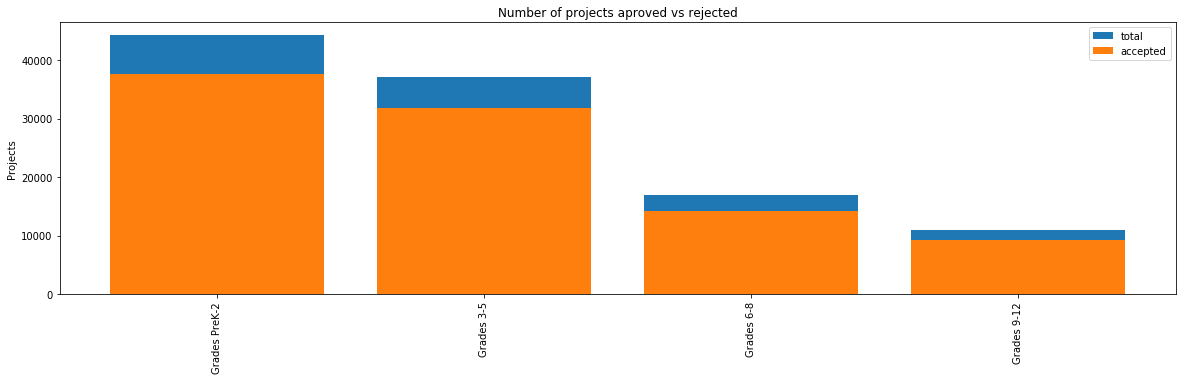

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [21]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

**Key Take away**:

**1. There is a some of variability on the number of projects submitted across project grade category  . ** 

**2. It has been observed that Grades 3-5 category is received the above average project acceptance rate.  **


### 1.2.4 Univariate Analysis: project_subject_categories

In [22]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [23]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

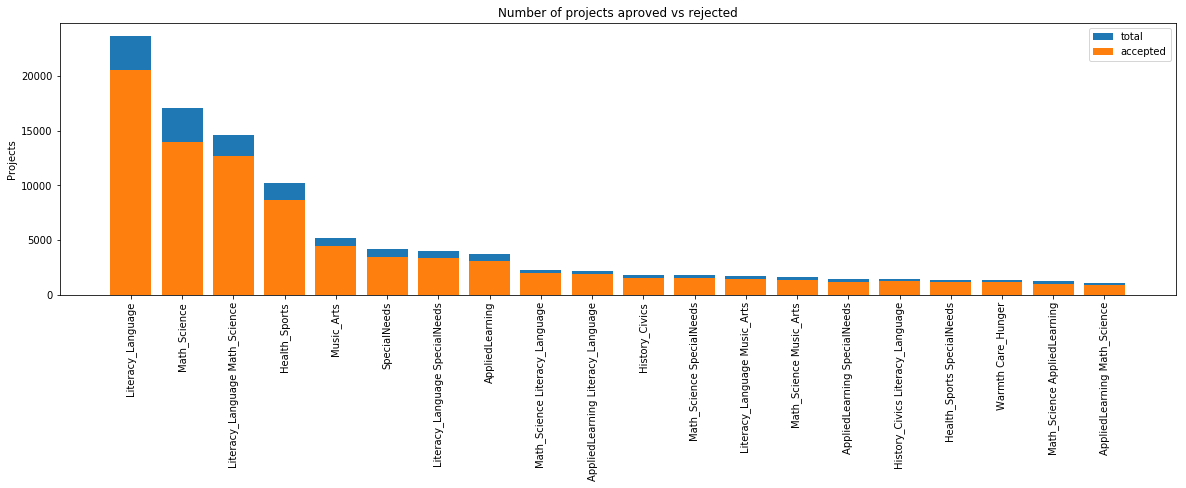

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [24]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)


**Key Take away**:

**1. There is a lot of variability on the number of projects and project approval rate per cleaned category. ** 

**2. It has been observed that Literacy Language
 has above average approval rate but when its coupled with other project category it has even higher approval rate. “ Warmth Care_Hunger”
cleaned category has highest approval rate
.  **


In [25]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

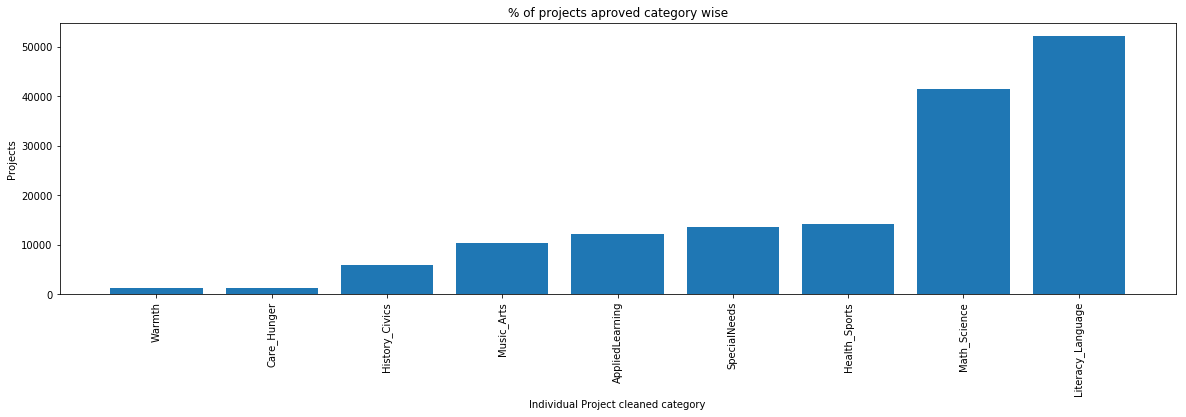

In [26]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.xlabel('Individual Project cleaned category')
plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()),rotation='vertical')
plt.show()

In [27]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


**Key Take away**:

**1. There is a huge of variability on each Individual cleaned category. ** 

**2. It has been observed that Literacy is one of the Individual cleaned category which has the highest  numbers of project approval where as Economics is one of the Individual cleaned category which has the lowest  numbers of project approval. 
.  **


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [28]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [29]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

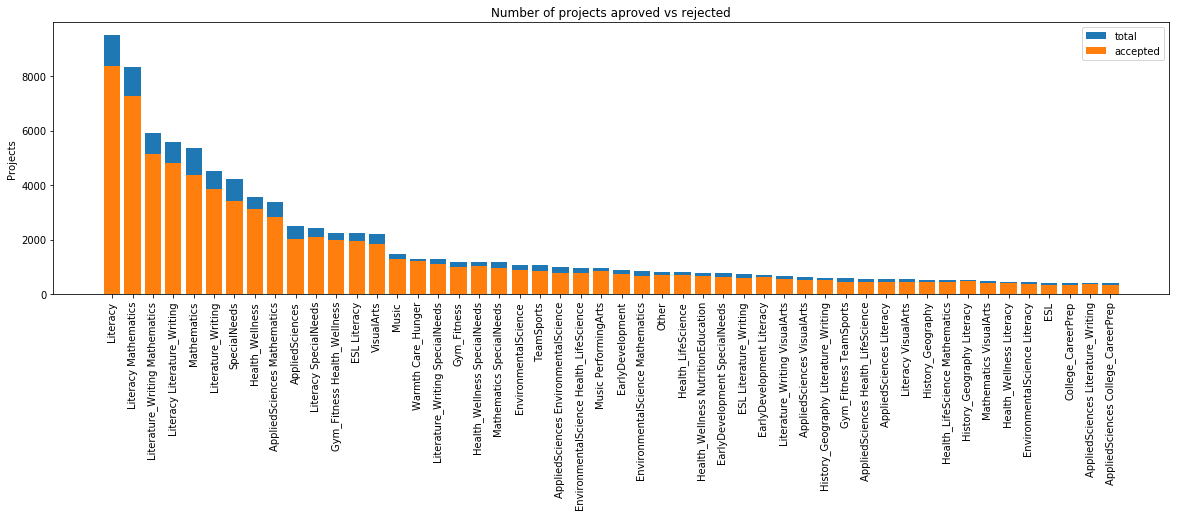

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [30]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)


**Key Take away**:

**1. There is a lot of variability on the number of projects and project approval rate per cleaned Subcategories. ** 

**2. It has been observed that Literacy has highest approval rate but when its coupled with other project Sub categories it has bit lower approval rate as compare to “Literacy” as individual project sub category but wherever “Literacy”  project approval rate is above average. 
  **


In [31]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

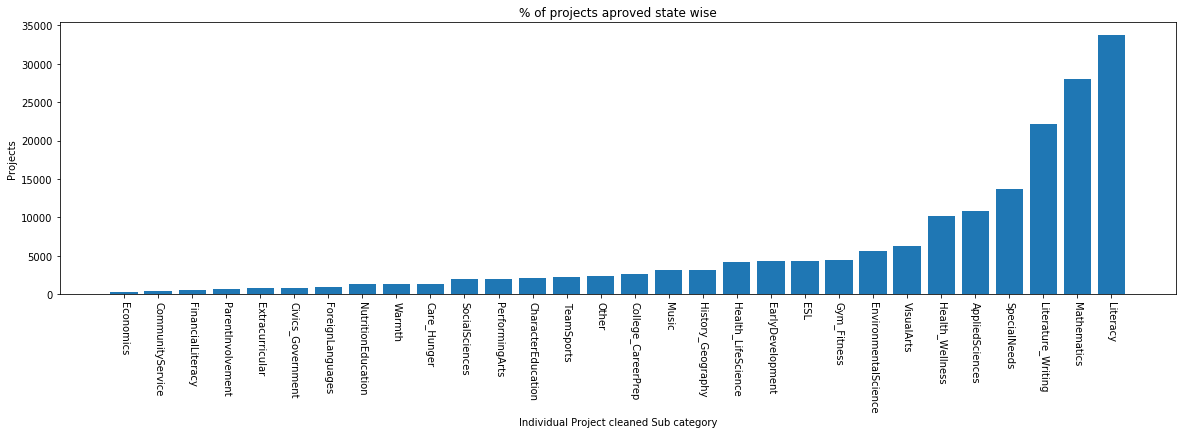

In [32]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.xlabel('Individual Project cleaned Sub category')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()),rotation='270')
plt.show()

In [33]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


**Key Take away**:

**1. There is a lot of variability on the % project approval states wise based on the cleaned project sub categories. ** 

**2. It has been observed that Literacy has highest approval rate whereas economics has the lowest approval rate project cleaned sub category. 
  **


### 1.2.6 Univariate Analysis: Text features (Title)

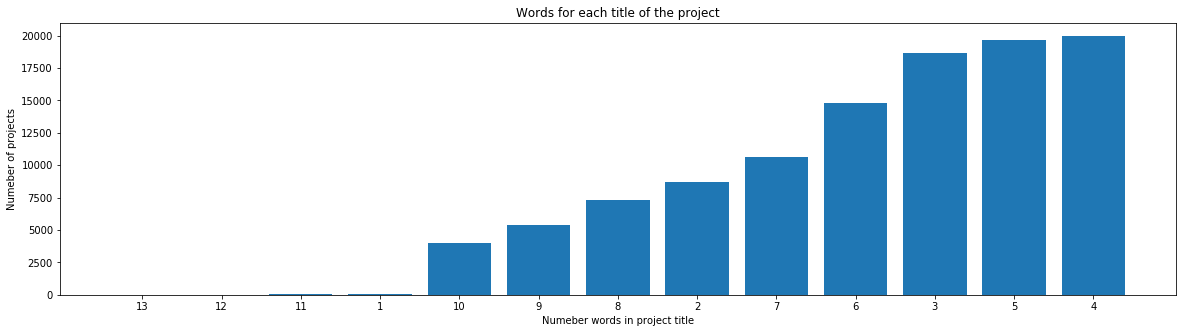

In [34]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

**Key Take away**:

**Most of the project has 4 to 7 letter in their title, that tells “number of words in project title”  is one of the key feature to predict whether Project will be approved or not. ** 


In [35]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

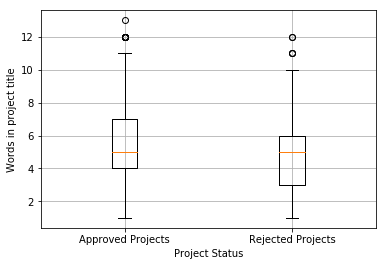

In [36]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.xlabel('Project Status')
plt.grid()
plt.show()

**Key Take away**:

**1. Median (50th percentile) of both “approved” and rejected Box plot is almost same. **

**2.  Based on upper quartile (75th percentile) of both the box plot , it has been observed that   “approved” project  has more number of words in their Title than the Rejected Project. ** 


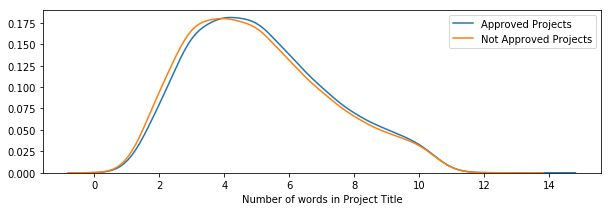

In [37]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.xlabel('Number of words in Project Title')
plt.legend()
plt.show()


**Key Take away**:

**1. Probability density plot line for approved project  is slightly ahead from the Probability density plot line of rejected project.(Based on no's word in Project Title) **

**2.  Based on Probability plot , it has been observed that  “approved” project  has  slightly more number of words in their Title than the Rejected Project. ** 


### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [38]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [39]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

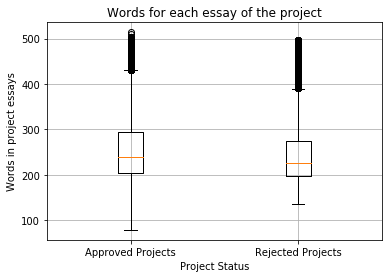

In [40]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.xlabel('Project Status')
plt.grid()
plt.show()

**Key Take away**:

**1. Median (50th percentile) of both “approved” and rejected Box plot is almost same. **

**2.  Based on upper quartile (75th percentile) of both the box plot , it has been observed that   “approved” project  has more number of words in each essay than the Rejected Project. ** 

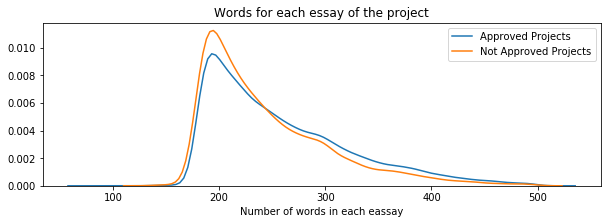

In [41]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

**Key Take away**:

**1. Probability density plot line for approved project  is slightly ahead from the Probability density plot line of rejected project.(Based on no's word in each essay of the ptoject) **

**2.  Based on Probability plot , it has been observed that  “approved” project  has  slightly more number of words in each essay than the Rejected Project. ** 

### 1.2.8 Univariate Analysis: Cost per project

In [42]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [43]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [44]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [45]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

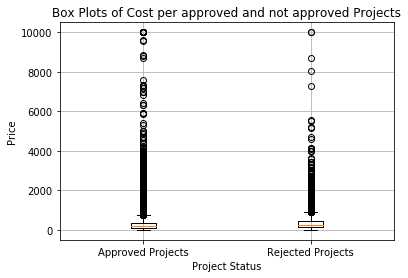

In [46]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.xlabel('Project Status')
plt.grid()
plt.show()

**Key Take away**:

**1.The box plots based on the cost is not intuitive enough to make prediction on project approval and rejection . **


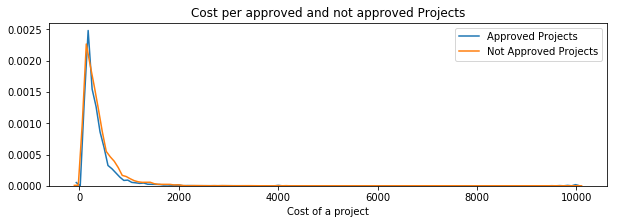

In [47]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

**Key Take away**:

**1. The Probability density plot based on the cost is also not informative to make predict project approval and rejection. **

**2. Certain places it shows that the cost of approved project is less than the rejected projects. **


In [48]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

**Key Take away**:
    
**Calculating the percentile and put them in a tabular format makes it clear that t the cost of approved project is less than the rejected projects at any given point of the data. **


<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

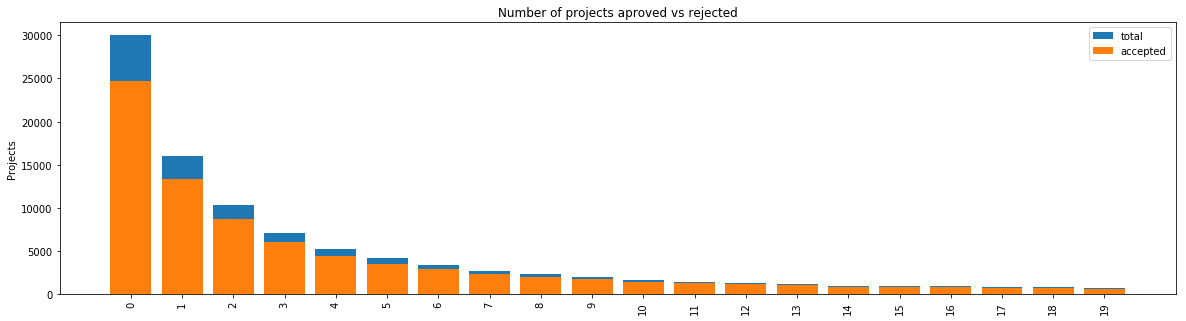

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
15                                            15                  818    942   
16                                            16                  769    894   
17                                            17                  712    803   
18                                            18                  666    772   
19                                       

In [49]:
univariate_barplots(project_data,'teacher_number_of_previously_posted_projects', 'project_is_approved' , top=20)

**Key Take away**:

**1. There is a lot of variability on project approval rate based on number of previously posted projects by teacher
. ** 

**2. It has been observed that the teachers who has been posting the project first time has highest numbers of project summation with 82% project approval rate.
**

** 3. based on the variability on the number of previously posted projects by teacher, its not concrete that this feature has strong impact on the project approval rates**


<h3><font color='red'>1.2.10 Univariate Analysis: project_resource_summary</font></h3>

In [50]:
# counting number of numerical digit in project_resource_summary data. 
#https://stackoverflow.com/questions/46079185/counting-how-many-times-a-digit-occurs-in-each-string-in-a-column-not-working-pr

DigitCount= project_data.project_resource_summary.str.count(r'\d')

#DigitCount.head(2)

In [51]:
#Appending the numerical digit count array into project_data file 
project_data['DigitCount'] = DigitCount
#project_data.head(2) 


In [52]:
#Creating a Boolean feature “ presence_of_numerical_digits” that will flag “1” if aleat ome numerical digit will be available in the project_resource_summary
# taken reference from this site for lambda function - https://stackoverflow.com/questions/1585322/is-there-a-way-to-perform-if-in-pythons-lambda


presence_of_numerical_digits = project_data.DigitCount.apply(lambda x : 1 if x>=1 else 0 ) 
#presence_of_numerical_digits.head(2)

In [53]:
#Appending the Boolean feature “ presence_of_numerical_digits” array into project_data file 
project_data['presence_of_numerical_digits'] = presence_of_numerical_digits
#project_data.head(2)

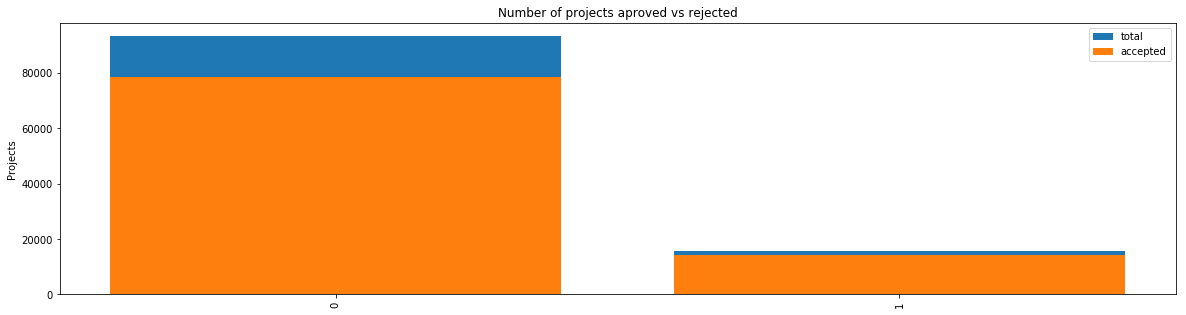

   presence_of_numerical_digits  project_is_approved  total       Avg
0                             0                78616  93492  0.840885
1                             1                14090  15756  0.894263
   presence_of_numerical_digits  project_is_approved  total       Avg
0                             0                78616  93492  0.840885
1                             1                14090  15756  0.894263


In [54]:
univariate_barplots(project_data,'presence_of_numerical_digits', 'project_is_approved' , top= False )

**Key Take away**:

**1. There is a some of variability on project approval rate based on presence of numerical digits in project resource summary. 
. ** 

**2. It has been observed that **

   **2.1 the presence of at least one numerical digit in project resource summary leads 89 % project approval rate.**

   **2.2 Project resource summary which doesn’t have any numerical digits has 84  % project approval rate**

** 3. based on the variability on the presence of numerical digits in project resource summary. , it’s not tangible that this feature has strong impact on the project approval rates**



## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [55]:
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05-12-2016 13:43          Grades PreK-2   
1           FL           25-10-2016 09:22             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   

               ...               \
0              ...                
1              ...                

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                            0                   0   
1                                            7                   1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price quantity  \
0  My students are English learners that are work...  154.6       23   
1  Our students arrive to our school eager to lea...  299.0        1   

   DigitCount  presence_of_numerical_digits  
0           0                             0  
1           0                             0  

[2 rows x 22 columns]

In [56]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [57]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [59]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [60]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [61]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [62]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:55<00:00, 1980.66it/s]


In [63]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h3><font color='red'>1.3.2 Project title Text</font></h3>

In [64]:
# Data processing for project titles 
Title_clean = project_data.project_title
Title_clean.head(2)

0    Educational Support for English Learners at Home
1               Wanted: Projector for Hungry Learners
Name: project_title, dtype: object

In [65]:
P = decontracted(project_data['project_title'].values[1])
print(P)

Wanted: Projector for Hungry Learners


In [66]:
# \r \n \t  and -- remove from string python: http://texthandler.com/info/remove-line-breaks-python/
P = P.replace('\\r', ' ')
P = P.replace('\\"', ' ')
P = P.replace('\\n', ' ')
P = P.replace('--', ' ')
print(P)

Wanted: Projector for Hungry Learners


In [67]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_Titles = []
# tqdm is for printing the status bar
for Pance in tqdm(project_data['project_title'].values):
    P = decontracted(Pance)
    P = P.replace('\\r', ' ')
    P = P.replace('\\"', ' ')
    P = P.replace('\\n', ' ')
    P = re.sub('[^A-Za-z0-9]+', ' ', P)
    # https://gist.github.com/sebleier/554280
    P = ' '.join(e for e in P.split() if e not in stopwords)
    preprocessed_Titles.append(P.lower().strip())


100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 44481.07it/s]


In [68]:
# after preprocesing
preprocessed_Titles[1:4]

['wanted projector hungry learners',
 'soccer equipment awesome middle school students',
 'techie kindergarteners']

## 1. 4 Preparing data for models

In [69]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'DigitCount', 'presence_of_numerical_digits'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

**Project_categories - Vectorization**

In [70]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


**Project_sub_categories - Vectorization** 

In [71]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


**School_State - Vectorization** 

In [72]:
# we use count vectorizer to convert the values into one hot encoded features 
from collections import Counter
my_counter_state = Counter()
for word in project_data['school_state'].values:
    my_counter_state.update(word.split())

state_dict = dict(my_counter_state)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(state_dict.keys()), lowercase=False, binary=True)

vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",state_one_hot.shape)

['IN', 'FL', 'AZ', 'KY', 'TX', 'CT', 'GA', 'SC', 'NC', 'CA', 'NY', 'OK', 'MA', 'NV', 'OH', 'PA', 'AL', 'LA', 'VA', 'AR', 'WA', 'WV', 'ID', 'TN', 'MS', 'CO', 'UT', 'IL', 'MI', 'HI', 'IA', 'RI', 'NJ', 'MO', 'DE', 'MN', 'ME', 'WY', 'ND', 'OR', 'AK', 'MD', 'WI', 'SD', 'NE', 'NM', 'DC', 'KS', 'MT', 'NH', 'VT']
Shape of matrix after one hot encodig  (109248, 51)


**teacher_prefix - Vectorization** 

In [73]:
#“Teacher prefix” data having the dots(.) and its has been observed the some rows are  empty in  this feature . 
#the dot(.) and  empty row available in the data consider as float datatype and it does not 
# accepted by the .Split() – Pandas function , so removing the same. 
# cleaning has been done for the same following references are used 
# 1.	Removing (.) from dataframe column - used ".str.replce" funtion (padas documentation)
# 2.	for  empty cell in datafram column - added the "Mrs." (in train data.cvs) which has me mostly occured in data set. 

project_data["teacher_prefix_clean"] = project_data["teacher_prefix"].str.replace(".","")
project_data.head(2)
print(project_data.teacher_prefix_clean.shape)


(109248,)


In [74]:
from collections import Counter
my_counter_T = Counter()
for word in project_data["teacher_prefix_clean"].values:
       
        my_counter_T.update(word.split())
       
    
       
Teacher_dict = dict(my_counter_T)
sorted_Teacher_dict = dict(sorted(Teacher_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(Teacher_dict.keys()), lowercase=False, binary=True)

vectorizer.fit(project_data.teacher_prefix_clean.values)
print(vectorizer.get_feature_names())


Teacher_Prefix_one_hot = vectorizer.transform(project_data.teacher_prefix_clean.values)
print("Shape of matrix after one hot encodig ",Teacher_Prefix_one_hot.shape)

['Mrs', 'Mr', 'Ms', 'Teacher', 'Dr']
Shape of matrix after one hot encodig  (109248, 5)


**project_grade_category - Vectorization** 

In [75]:
# Used this as reference to avoide the space between grades and category , 
# it has split the string with comma , now getting four project grade category as required. 
# https://stackoverflow.com/questions/4071396/split-by-comma-and-strip-whitespace-in-python
from collections import Counter
my_counter_project_grade_category= Counter()
for word in project_data['project_grade_category'].values:
    my_counter_project_grade_category.update(word.split(','))

project_grade_category_dict = dict(my_counter_project_grade_category)
sorted_project_grade_category_prefix_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(project_grade_category_dict.keys()), lowercase=False, binary=True)

vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)


['Grades PreK-2', 'Grades 6-8', 'Grades 3-5', 'Grades 9-12']
Shape of matrix after one hot encodig  (109248, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [76]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


<h4><font color='red'> 1.4.2.2 Bag of Words on `project_title`</font></h4>

In [77]:
vectorizer = CountVectorizer(min_df=10)
text_bow_title = vectorizer.fit_transform(preprocessed_Titles)
print("Shape of matrix after one hot encodig ",text_bow_title.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.3 TFIDF vectorizer

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


<h4><font color='red'> 1.4.2.4 TFIDF Vectorizer on `project_title`</font></h4>

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_project_titles = vectorizer.fit_transform(preprocessed_Titles)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [109]:

# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')



Loading Glove Model


1917495it [05:06, 6254.65it/s]


Done. 1917495  words loaded!


In [120]:
words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))

for i in preprocessed_Titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

all the words in the coupus 17014267
the unique words in the coupus 58968
The number of words that are present in both glove vectors and our coupus 51503 ( 87.341 %)
word 2 vec length 51503


In [121]:
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

In [80]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [81]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:28<00:00, 3851.78it/s]


109248
300


<h4><font color='red'> 1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`</font></h4>

In [82]:
# average Word2Vec
# compute average word2vec for each project_titles.
avg_w2v_vectors_project_titles = []; # the avg-w2v for each project_title is stored in this list
for sentence in tqdm(preprocessed_Titles): # for each project_title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the project_title
    for word in sentence.split(): # for each word in a project_title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_project_titles.append(vector)

print(len(avg_w2v_vectors_project_titles))
print(len(avg_w2v_vectors_project_titles[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 75117.39it/s]


109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [83]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [84]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [03:31<00:00, 515.81it/s]


109248
300


<h4><font color='red'> 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title`</font></h4>

In [85]:
# # average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_project_titles = []; # the avg-w2v for each project_title is stored in this list
for sentence in tqdm(preprocessed_Titles): # for each project_title
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the project_title
    for word in sentence.split(): # for each word in a project_title
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_project_titles.append(vector)

print(len(tfidf_w2v_vectors_project_titles))
print(len(tfidf_w2v_vectors_project_titles[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:03<00:00, 34860.18it/s]


109248
300


### 1.4.3 Vectorizing Numerical features

### 1.4.3.1 Vectorizing Numerical features - Price 

In [86]:
# the cost feature is already in numerical values,  we are going to represent the money, as numerical values within the range 0-1
# normalization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_normalized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_normalized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [87]:
price_normalized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

### 1.4.3.2 Vectorizing Numerical features - teacher_number_of_previously_posted_projects

In [88]:
import warnings 
warnings.filterwarnings("ignore")

prev_post_scalar = StandardScaler()
prev_post_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# for avoiding thef-string refered  - https://github.com/wemake-services/wemake-python-styleguide/issues/32
print("Mean :{}".format(prev_post_scalar.mean_[0]))
print("Standard deviation :{}".format({np.sqrt(prev_post_scalar.var_[0])}))
                                       
# Now standardize the data with above maen and variance.
prev_post_normalized = prev_post_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean :11.153165275336848
Standard deviation :{27.77702641477403}


In [89]:
prev_post_normalized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [90]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_normalized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [91]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_normalized))
X.shape

(109248, 16663)

<h1><font color='red'>Assignment 2: Apply TSNE<font></h1>

 <font color=#F4274F>If you are using any code snippet from the internet, you have to provide the reference/citations, as we did in the above cells. Otherwise, it will be treated as plagiarism without citations.</font>

<ol> 
    <li> In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.</li>
    <li> EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects</li>
    <li>
        <ul>Build the data matrix using these features 
            <li>school_state : categorical data (one hot encoding)</li>
            <li>clean_categories : categorical data (one hot encoding)</li>
            <li>clean_subcategories : categorical data (one hot encoding)</li>
            <li>teacher_prefix : categorical data (one hot encoding)</li>
            <li>project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)</li>
            <li>price : numerical</li>
            <li>teacher_number_of_previously_posted_projects : numerical</li>
         </ul>
    </li>
    <li> Now, plot FOUR t-SNE plots with each of these feature sets.
        <ol>
            <li>categorical, numerical features + project_title(BOW)</li>
            <li>categorical, numerical features + project_title(TFIDF)</li>
            <li>categorical, numerical features + project_title(AVG W2V)</li>
            <li>categorical, numerical features + project_title(TFIDF W2V)</li>
        </ol>
    </li>
    <li> Concatenate all the features and Apply TNSE on the final data matrix </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using</font></li>
</ol>

# Assignments -  


**1. In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.**

**Performed in respective place , above in this sheet **

**2.EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects**
        
**Performed in respective place , above in this sheet **

**3. Build the data matrix using these features**

school_state : categorical data (one hot encoding)

clean_categories : categorical data (one hot encoding)

clean_subcategories : categorical data (one hot encoding)

teacher_prefix : categorical data (one hot encoding)

project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)

price : numerical

teacher_number_of_previously_posted_projects : numerical

In [92]:
#Converting this feature to data Frame as this has been created as list. 
#We need to perform data merging and plotting, which needs this list to be in Data frame format 
tfidf_w2v_vectors_project_titles = pd.DataFrame(tfidf_w2v_vectors_project_titles)
tfidf_w2v_vectors_project_titles.shape

(109248, 300)

In [93]:
#Converting this feature to data Frame as this has been created as list. 
#We need to perform data merging and plotting, which needs this list to be in Data frame format 
avg_w2v_vectors_project_titles = pd.DataFrame(avg_w2v_vectors_project_titles)
avg_w2v_vectors_project_titles.shape

(109248, 300)

In [94]:
#Checking shape of all required features before merging them to one Data Matrix 
print(state_one_hot.shape)
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(Teacher_Prefix_one_hot.shape)
print(text_bow_title.shape)
print(text_tfidf_project_titles.shape)
print(avg_w2v_vectors_project_titles.shape)
print(tfidf_w2v_vectors_project_titles.shape)
print(price_normalized.shape)
print(prev_post_normalized.shape)


(109248, 51)
(109248, 9)
(109248, 30)
(109248, 5)
(109248, 3329)
(109248, 3329)
(109248, 300)
(109248, 300)
(109248, 1)
(109248, 1)


In [120]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
t_SNE_data = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,text_bow_title,text_tfidf_project_titles,avg_w2v_vectors_project_titles,
tfidf_w2v_vectors_project_titles,price_normalized,Teacher_Prefix_one_hot,prev_post_normalized))
t_SNE_data.shape


(109248, 7355)

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [ ]:
# AS per the assigment direction , creating the Data matrix for categorical, numerical features + project_title(BOW)
from scipy.sparse import hstack
t_SNE_BOW_data_matrix = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,Teacher_Prefix_one_hot,text_bow_title,price_normalized,prev_post_normalized))
t_SNE_BOW_data_matrix.shape


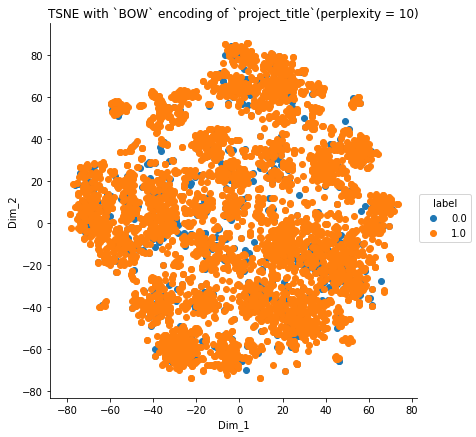

In [137]:
#'TSNE with `BOW` encoding of `project_title`(perplexity = 10)#

from sklearn.manifold import TSNE

# Converting the Sparse matrix to dense matrix 
# referred the this link https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144

t_SNE_BOW =t_SNE_BOW_data_matrix.toarray()

# Picking 5000 data points for T-SNE 

t_SNE_BOW = t_SNE_BOW[:5000,:]

# For plotting T-SNE – code from applied AI course has been taken 
#(T-SNE and sample code suggested in assignment video and iPython provided) 

model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(t_SNE_BOW) 

# configuring the parameteres
# the number of components = 2
# perplexity = 10
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with `BOW` encoding of `project_title`(perplexity = 10)')
plt.show()



**Key Take away**:

**1. All the points scatter across the plot area. ** 

**2.  The class labels are not intuitive separated to draw any valuable conclusion out of the plot.**


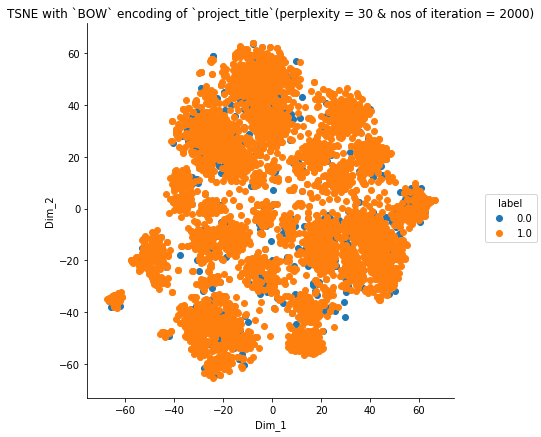

In [140]:
#'TSNE with `BOW` encoding of `project_title`(perplexity = 30 , no's of iteration = 2000)#

model = TSNE(n_components=2, random_state=0, perplexity=30 , n_iter=2000)
tsne_data = model.fit_transform(t_SNE_BOW) 

# configuring the parameteres
# the number of components = 2
# perplexity = 30
# default learning rate = 200
# number of iterations for the optimization = 2000

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with `BOW` encoding of `project_title`(perplexity = 30 & nos of iteration = 2000)')
plt.show()


**Key Take away**:

**Changed the perplexity = 30 , no's of iteration = 2000 , even arrived in the same conclusion.**

**1. All the points scatter across the plot area. **

**2.  Plot is not intuitive enough to draw any valuable conclusion. 
  **


<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [142]:
# AS per the assigment direction , creating the Data matrix for categorical, numerical features + project_title(BOW)
from scipy.sparse import hstack
t_SNE_TFIDF_data_matrix = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,Teacher_Prefix_one_hot,text_tfidf_project_titles,price_normalized,prev_post_normalized))
t_SNE_TFIDF_data_matrix.shape

(109248, 3426)

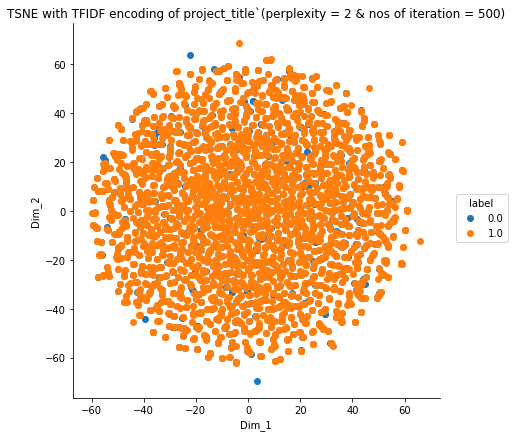

In [143]:
#'TSNE with TFIDF encoding of project_title`(perplexity = 2 & no's of iteration = 500)#

from sklearn.manifold import TSNE

# Converting the Sparse matrix to dense matrix 
# referred the this link https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144

t_SNE_TFIDF =t_SNE_TFIDF_data_matrix.toarray()

# Picking 5000 data points for T-SNE 

t_SNE_TFIDF = t_SNE_TFIDF[:5000,:]

# For plotting T-SNE – code from applied AI course has been taken 
#(T-SNE and sample code suggested in assignment video and iPython provided) 

model = TSNE(n_components=2, random_state=0, perplexity=2 ,n_iter= 500)
tsne_data = model.fit_transform(t_SNE_TFIDF) 

# configuring the parameteres
# the number of components = 2
# perplexity = 2
# default learning rate = 200
# default Maximum number of iterations for the optimization = 500

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with TFIDF encoding of project_title`(perplexity = 2 & nos of iteration = 500)')
plt.show()


**Key Take away**:
**With Perplexity =2 , points are become closed and made a circular shape **

**1. All the points scatter across the plot area. ** 

**2.  The class labels are not intuitive separated (over lapping to each other) to draw any valuable conclusion out of the plot.** 


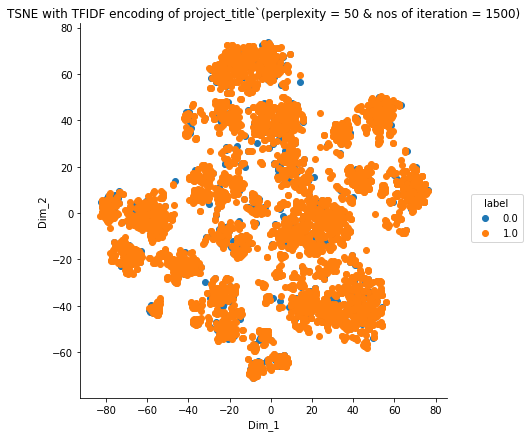

In [144]:
#'TSNE with TFIDF encoding of project_title`(perplexity = 50 & no's of iteration = 1500)#

model = TSNE(n_components=2, random_state=0, perplexity=50 ,n_iter= 1500)
tsne_data = model.fit_transform(t_SNE_TFIDF) 

# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1500

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with TFIDF encoding of project_title`(perplexity = 50 & nos of iteration = 1500)')
plt.show()

**Key Take away**:

**Changed the perplexity = 50 , no's of iteration = 1500, small cluster formation has been seen in the plots ,**

**but still all the points over lapping to each other to draw any valuable conclusion out of the plot. **


<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [146]:
# AS per the assigment direction , creating the Data matrix for categorical, numerical features + project_title(BOW)
from scipy.sparse import hstack
t_SNE_AVG_W2V_data_matrix = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,Teacher_Prefix_one_hot,avg_w2v_vectors_project_titles,price_normalized,prev_post_normalized))
t_SNE_AVG_W2V_data_matrix.shape

(109248, 397)

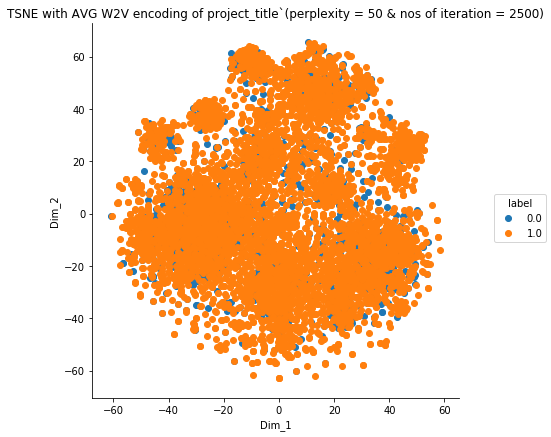

In [147]:
#'TSNE with AVG W2V encoding of project_title`(perplexity = 50 & no's of iteration = 2500)#

from sklearn.manifold import TSNE

# Converting the Sparse matrix to dense matrix 
# referred the this link https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144

t_SNE_AVG_W2V =t_SNE_AVG_W2V_data_matrix.toarray()

# Picking 5000 data points for T-SNE 

t_SNE_AVG_W2V = t_SNE_AVG_W2V[:5000,:]

# For plotting T-SNE – code from applied AI course has been taken 
#(T-SNE and sample code suggested in assignment video and iPython provided) 

model = TSNE(n_components=2, random_state=0, perplexity=50 ,n_iter= 2500)
tsne_data = model.fit_transform(t_SNE_AVG_W2V) 

# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# default Maximum number of iterations for the optimization = 2500

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with AVG W2V encoding of project_title`(perplexity = 50 & nos of iteration = 2500)')
plt.show()


**Key Take away**:

**1. All the points scatter across the plot area. ** 

**2.  The class labels are not intuitive separated to draw any valuable conclusion out of the plot.**

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [149]:
# AS per the assigment direction , creating the Data matrix for categorical, numerical features + project_title(BOW)
from scipy.sparse import hstack
t_SNE_TFIDF_WTD_W2V_data_matrix = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,Teacher_Prefix_one_hot,tfidf_w2v_vectors_project_titles,price_normalized,prev_post_normalized))
t_SNE_TFIDF_WTD_W2V_data_matrix.shape

(109248, 397)

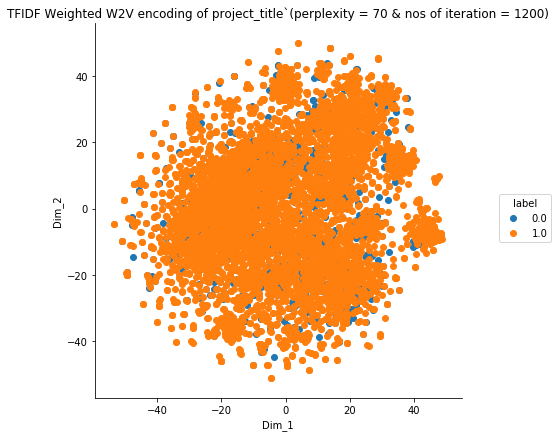

In [150]:
#TFIDF Weighted W2V encoding of project_title`(perplexity = 70 & no's of iteration = 1200)#

from sklearn.manifold import TSNE

# Converting the Sparse matrix to dense matrix 
# referred the this link https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144

t_SNE_TFIDF_AVG_W2V =t_SNE_TFIDF_WTD_W2V_data_matrix.toarray()

# Picking 5000 data points for T-SNE 

t_SNE_TFIDF_AVG_W2V = t_SNE_TFIDF_AVG_W2V[:5000,:]

# For plotting T-SNE – code from applied AI course has been taken 
#(T-SNE and sample code suggested in assignment video and iPython provided) 

model = TSNE(n_components=2, random_state=0, perplexity=70 ,n_iter= 1200)
tsne_data = model.fit_transform(t_SNE_TFIDF_AVG_W2V) 

# configuring the parameteres
# the number of components = 2
# perplexity = 70
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1200

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TFIDF Weighted W2V encoding of project_title`(perplexity = 70 & nos of iteration = 1200)')
plt.show()

**Key Take away**:

**1. All the points scatter across the plot area. ** 

**2.  The class labels are not intuitive separated to draw any valuable conclusion out of the plot.**

<h2> 2.5 TSNE with All Mentioned features </h2>

In [151]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
t_SNE_ALL_data = hstack((state_one_hot,categories_one_hot,sub_categories_one_hot,text_bow_title,text_tfidf_project_titles,avg_w2v_vectors_project_titles,
tfidf_w2v_vectors_project_titles,price_normalized,Teacher_Prefix_one_hot,prev_post_normalized))
t_SNE_ALL_data.shape


(109248, 7355)

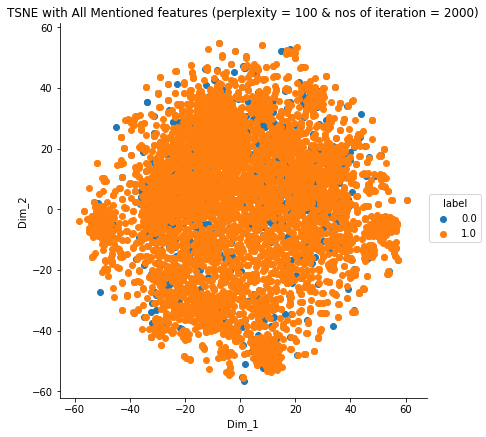

In [152]:
#TSNE with All Mentioned features (perplexity = 100 & no's of iteration = 2000)#

from sklearn.manifold import TSNE

# Converting the Sparse matrix to dense matrix 
# referred the this link https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144

t_SNE_ALL =t_SNE_ALL_data.toarray()

# Picking 5000 data points for T-SNE 

t_SNE_ALL = t_SNE_ALL[:5000,:]

# For plotting T-SNE – code from applied AI course has been taken 
#(T-SNE and sample code suggested in assignment video and iPython provided) 

model = TSNE(n_components=2, random_state=0, perplexity=70 ,n_iter= 1200)
tsne_data = model.fit_transform(t_SNE_ALL) 

# configuring the parameteres
# the number of components = 2
# perplexity = 100
# default learning rate = 200
# default Maximum number of iterations for the optimization = 2000

# Defining Class label 
label= project_data["project_is_approved"]
t_SNE_label = label[0:5000]
t_SNE_label.shape

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, t_SNE_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with All Mentioned features (perplexity = 100 & nos of iteration = 2000)')
plt.show()

**Key Take away**:

**1. All the points scatter across the plot area. ** 

**2.  The class labels are not intuitive separated to draw any valuable conclusion out of the plot.**

<h2> 2.6 Conclusions </h2>

**Output points of all T-SNE of BOW , TFIDF , Word to Vec (W2V) and TFIDF weighted Word to Vec**
 **with other numerical and categorical feature are scattered across the graph, overlapping with each other, it does not give any valuable information. **
**Even running Different scenarios with variable perplexity from 10 to 100 and iteration rate from** **500 to 2500. but output points are **
**not well separated and overlapping with each other. **
 
**That leads to the conclusion that T-SNE  is not a suitable method to **
**decided Project will be approved or not approved with provided feature and one will not able to decide to**
** build any specific classification model based on T-SNE and EDA in this case. **
